# Final Project - Advanced Topics in Deep Learning
---
<br>

### Name and ID:
Student 1: Stav Elizur
<br>
Student 2: Albert Abiev
<br>
Student 3: Tommy Afek
<br>
Student 4: Daniel Oleynyk

# CycleGan

## Utils

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow import keras
!pip install tensorflow-addons
!pip install -U --no-cache-dir gdown --pre
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

!gdown --id 1Ce_JeGw1JwXGikiyVxi15vsNg_dC1ggS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Ce_JeGw1JwXGikiyVxi15vsNg_dC1ggS
To: /content/explainer.md
100% 2.87k/2.87k [00:00<00:00, 2.86MB/s]


Download kaggle dataset with kaggle.json

In [ ]:
!pip install kaggle
! mkdir ~/.kaggle
!echo "{\"username\":\"stavelizur\",\"key\":\"keyexample\"}" > ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download gan-getting-started
! mkdir kaggle
! mkdir kaggle/input
! mkdir kaggle/input/gan-getting-started
! unzip gan-getting-started.zip -d kaggle/input/gan-getting-started
!cd /content/

Streaming output truncated to the last 5000 lines.
  inflating: kaggle/input/gan-getting-started/photo_jpg/46e71a4094.jpg  
  inflating: kaggle/input/gan-getting-started/photo_jpg/46e84039a1.jpg  
  inflating: kaggle/input/gan-getting-started/photo_jpg/46f391abec.jpg  
  inflating: kaggle/input/gan-getting-started/photo_jpg/46f5ef1042.jpg  
  inflating: kaggle/input/gan-getting-started/photo_jpg/4706619607.jpg  
  inflating: kaggle/input/gan-getting-started/photo_jpg/4707b03a08.jpg  
  inflating: kaggle/input/gan-getting-started/photo_jpg/47100a9939.jpg  
  inflating: kaggle/input/gan-getting-started/photo_jpg/471f4755b9.jpg  
  inflating: kaggle/input/gan-getting-started/photo_jpg/472b351bc4.jpg  
  inflating: kaggle/input/gan-getting-started/photo_jpg/472d5ac100.jpg  
  inflating: kaggle/input/gan-getting-started/photo_jpg/4758e5dd4c.jpg  
  inflating: kaggle/input/gan-getting-started/photo_jpg/4762bb79ef.jpg  
  inflating: kaggle/input/gan-getting-started/photo_jpg/4778b13518.jpg  


### For TPU usage

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


## Hyper Parameters

In [ ]:
# Define the standard image size.
orig_img_size = (320, 320)
input_img_size = (320, 320, 3)

# Weights initializer for the layers.
kernel_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Gamma initializer for instance normalization.
gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

shuffle_size = 256
batch_size = 1

## Preprocessing

Create augmentation for images and normalize the image.

In [ ]:
def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    return (img / 255)

def preprocess_train_image(img):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 320X320
    img = tf.image.random_crop(img, size=[*input_img_size])
    img = normalize_img(img)
    return img

def preprocess_test_image(img):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img


## Load Dataset

Load all dataset from directory

In [ ]:
base_dir = '/content/kaggle/input/gan-getting-started/'
photo_dir = 'photo_jpg'
monet_dir = 'monet_jpg'

MONET_FILENAMES = tf.io.gfile.glob(str(base_dir+"/" + monet_dir + '/*.jpg'))
print('Monet files: ', str(len(MONET_FILENAMES))) 

PHOTO_FILENAMES = tf.io.gfile.glob(str(base_dir + "/" + photo_dir + '/*.jpg'))
print('Photo files: ', str(len(PHOTO_FILENAMES)))

def load_image(file_path):
    image_string = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    return tf.data.Dataset.list_files(filenames).map(load_image)

def make_preprocess_stage(dataset):
    return dataset.map(preprocess_train_image, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(shuffle_size).batch(batch_size)

monet_dataset = make_preprocess_stage(load_dataset(MONET_FILENAMES, labeled=True))
photo_dataset = make_preprocess_stage(load_dataset(PHOTO_FILENAMES, labeled=True))

Monet files:  300
Photo files:  7038


### Show some photos from datasets

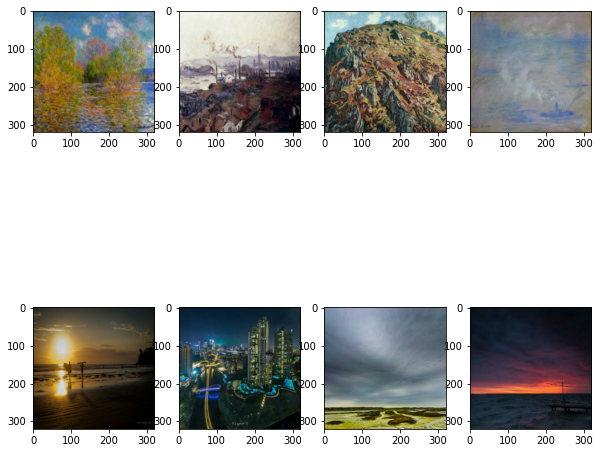

In [ ]:
plt.figure(figsize=(10,10))

for i, img in enumerate(monet_dataset.take(4)):
    plt.subplot(2,4,i+1)
    image = img[0]
    plt.imshow(image) 

for i, img in enumerate(photo_dataset.take(4)):
    plt.subplot(2,4,i+5)
    image = img[0]
    plt.imshow(image) 
    
plt.show()

## Building Cycle-Gan model

### Create layer of Reflection Padding

In [ ]:
class ReflectionPadding2D(layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        
        # We have to be sure that the input_tensor rank is 4
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")

### Create CycleGanModel Class

In [ ]:
class CycleGanModel():
    def __init__(self):
        self.cycle_gan_model = None
        self.history = None
        

### Create residual block architecture

In [ ]:
class CycleGanModel(CycleGanModel):
    @staticmethod
    def residual_block(model,
                       activation, 
                       kernel_initializer=kernel_init, 
                       kernel_size=(3, 3), 
                       strides=(1, 1), 
                       padding="valid", 
                       gamma_initializer=gamma_init, 
                       use_bias=False):
        dim = model.shape[-1]
        input_tensor = model

        model_block = ReflectionPadding2D()(input_tensor)
        model_block = layers.Conv2D(
            dim,
            kernel_size,
            strides=strides,
            kernel_initializer=kernel_initializer,
            padding=padding,
            use_bias=use_bias,
        )(model_block)
        model_block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(model_block)
        model_block = activation(model_block)

        model_block = ReflectionPadding2D()(model_block)
        model_block = layers.Conv2D(
            dim,
            kernel_size,
            strides=strides,
            kernel_initializer=kernel_initializer,
            padding=padding,
            use_bias=use_bias,
        )(model_block)
        model_block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(model_block)
        model_block = layers.add([input_tensor, model_block])
        return model_block

### Create down sample block architecture

In [ ]:
class CycleGanModel(CycleGanModel):
    @staticmethod
    def down_sample(model,
                    filters, 
                    activation, 
                    kernel_initializer=kernel_init, 
                    kernel_size=(3, 3), 
                    strides=(2, 2), 
                    padding="same", 
                    gamma_initializer=gamma_init, 
                    use_bias=False):
        down_Sample_block = layers.Conv2D(
            filters,
            kernel_size,
            strides=strides,
            kernel_initializer=kernel_initializer,
            padding=padding,
            use_bias=use_bias,
        )(model)
        down_Sample_block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(down_Sample_block)
        if activation:
            down_Sample_block = activation(down_Sample_block)
        return down_Sample_block

### Create up sample block architecture

In [ ]:
class CycleGanModel(CycleGanModel):
    @staticmethod
    def up_sample(model,
                  filters, 
                  activation, 
                  kernel_size=(3, 3), 
                  strides=(2, 2), 
                  padding="same", 
                  kernel_initializer=kernel_init, 
                  gamma_initializer=gamma_init, 
                  use_bias=False):
        up_sample_block = layers.Conv2DTranspose(
            filters,
            kernel_size,
            strides=strides,
            padding=padding,
            kernel_initializer=kernel_initializer,
            use_bias=use_bias,
        )(model)
        up_sample_block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(up_sample_block)
        if activation:
            up_sample_block = activation(up_sample_block)
        return up_sample_block

### Build Generator architecture

Generator consists some down sample layers and then some residual blocks that connected each other between the input and output and then some up sample layers.

In [ ]:
class CycleGanModel(CycleGanModel):
    @staticmethod
    def create_generator(filters=64, 
                         num_downsampling_blocks=2, 
                         num_residual_blocks=9, 
                         num_upsample_blocks=2, 
                         gamma_initializer=gamma_init, 
                         name=None):
        input_layer = layers.Input(shape=input_img_size, name=name + "_img_input")
        model = ReflectionPadding2D(padding=(3, 3))(input_layer)
        model = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(model)
        model = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(model)
        model = layers.Activation("relu")(model)

        # Downsampling
        for _ in range(num_downsampling_blocks):
            filters *= 2
            model = CycleGanModel.down_sample(model, filters=filters, activation=layers.Activation("relu"))

        # Residual blocks
        for _ in range(num_residual_blocks):
            model = CycleGanModel.residual_block(model, activation=layers.Activation("relu"))

        # Upsampling
        for _ in range(num_upsample_blocks):
            filters //= 2
            model = CycleGanModel.up_sample(model, filters, activation=layers.Activation("relu"))

        # Final block
        model = ReflectionPadding2D(padding=(3, 3))(model)
        model = layers.Conv2D(3, (7, 7), padding="valid")(model)
        model = layers.Activation("tanh")(model)

        return keras.models.Model(input_layer, model, name=name)

### Build Discriminator architecture

Discriminator is PatchGan with 32x32 receptive field

In [ ]:
class CycleGanModel(CycleGanModel):
    @staticmethod
    def create_discriminator(filters=64, 
                             kernel_initializer=kernel_init, 
                             num_downsampling=3, 
                             name=None):
        # Calculate the number of filters in the first layer based on the patch size
        first_filters = int(filters / 2 ** 3)

        # Input layer
        input_layer = layers.Input(shape=input_img_size, name='input_image')
        model = input_layer

        # Downsampling
        for _ in range(num_downsampling):
            model = CycleGanModel.down_sample(model, filters=first_filters, kernel_size=(4, 4),activation=layers.Activation("relu"))
            first_filters *= 2

        # Output layer
        model = layers.Conv2D(1, kernel_size=4, strides=1, padding='valid')(model)

        # Model
        return keras.models.Model(inputs=[input_layer], outputs=[model])

### Config Cycle-Gan train step

Config the train step, we defined the loss calculation.

In [ ]:
class CycleGanModel(CycleGanModel):
    class CycleGan(keras.Model):
        def __init__(self,
                     generator_monet,
                     generator_photo,
                     discriminator_photo,
                     discriminator_monet,
                     lambda_cycle=10.0,
                     lambda_identity=0.5):
            super().__init__()
            self.gen_monet = generator_monet
            self.gen_photo = generator_photo
            self.discriminator_photo = discriminator_photo
            self.discriminator_monet = discriminator_monet
            self.lambda_cycle = lambda_cycle
            self.lambda_identity = lambda_identity

        def compile(self,
                    gen_monet_optimizer,
                    gen_photo_optimizer,
                    disc_photo_optimizer,
                    disc_monet_optimizer,
                    gen_loss_function,
                    disc_loss_function):
            super().compile()
            self.gen_monet_optimizer = gen_monet_optimizer
            self.gen_photo_optimizer = gen_photo_optimizer
            self.disc_photo_optimizer = disc_photo_optimizer
            self.disc_monet_optimizer = disc_monet_optimizer
            self.generator_loss_fn = gen_loss_function
            self.discriminator_loss_fn = disc_loss_function
            self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
            self.identity_loss_fn = keras.losses.MeanAbsoluteError()

        def train_step(self, batch_data):
            print("train_step")
            real_photo, real_monet = batch_data

            with tf.GradientTape(persistent=True) as tape:
                # Cycle (Photo to fake monet to fake photo)
                fake_monet = self.gen_monet(real_photo, training=True)
                cycled_photo = self.gen_photo(fake_monet, training=True)
                
                # Cycle (Monet to fake photo to fake monet)
                fake_photo = self.gen_photo(real_monet, training=True)
                cycled_monet = self.gen_monet(fake_photo, training=True)

                # Identity mapping
                prediction_photo = self.gen_photo(real_photo, training=True)
                prediction_monet = self.gen_monet(real_monet, training=True)

                # Discriminator output on real images
                disc_real_photo = self.discriminator_photo(real_photo, training=True)
                disc_real_monet = self.discriminator_monet(real_monet, training=True)

                # Discriminator output on fake images
                disc_fake_photo = self.discriminator_photo(fake_photo, training=True)
                disc_fake_monet = self.discriminator_monet(fake_monet, training=True)

                # Generator adverserial loss
                gen_monet_loss = self.generator_loss_fn(disc_fake_monet)
                gen_photo_loss = self.generator_loss_fn(disc_fake_photo)

                # Generator cycle loss
                cycle_loss_monet = self.cycle_loss_fn(real_monet, cycled_monet) * self.lambda_cycle
                cycle_loss_photo = self.cycle_loss_fn(real_photo, cycled_photo) * self.lambda_cycle

                # Generator identity loss
                id_loss_monet = (
                    self.identity_loss_fn(real_monet, prediction_monet)
                    * self.lambda_cycle
                    * self.lambda_identity
                )
                id_loss_photo = (
                    self.identity_loss_fn(real_photo, prediction_photo)
                    * self.lambda_cycle
                    * self.lambda_identity
                )
                
                # Total generator loss
                total_loss_monet = gen_monet_loss + cycle_loss_monet + id_loss_monet
                total_loss_photo = gen_photo_loss + cycle_loss_photo + id_loss_photo

                # Discriminator loss
                disc_photo_loss = self.discriminator_loss_fn(disc_real_photo, disc_fake_photo)
                disc_monet_loss = self.discriminator_loss_fn(disc_real_monet, disc_fake_monet)
                
            # Get the gradients for the generators
            grads_monet = tape.gradient(total_loss_monet, self.gen_monet.trainable_variables)
            grads_photo = tape.gradient(total_loss_photo, self.gen_photo.trainable_variables)

            # Get the gradients for the discriminators
            disc_photo_grads = tape.gradient(disc_photo_loss, self.discriminator_photo.trainable_variables)
            disc_monet_grads = tape.gradient(disc_monet_loss, self.discriminator_monet.trainable_variables)

            # Update the weights of the generators
            self.gen_monet_optimizer.apply_gradients(
                zip(grads_monet, self.gen_monet.trainable_variables)
            )
            self.gen_photo_optimizer.apply_gradients(
                zip(grads_photo, self.gen_photo.trainable_variables)
            )

            # Update the weights of the discriminators
            self.disc_photo_optimizer.apply_gradients(
                zip(disc_photo_grads, self.discriminator_photo.trainable_variables)
            )
            self.disc_monet_optimizer.apply_gradients(
                zip(disc_monet_grads, self.discriminator_monet.trainable_variables)
            )

            return {
                "Photo_loss": total_loss_photo,
                "Monet_loss": total_loss_monet,
                "D_Photo_loss": disc_photo_loss,
                "D_Monet_loss": disc_monet_loss,
            }

### Build the specific model according to generators and discriminators

In [ ]:
class CycleGanModel(CycleGanModel):
    def build_cycle_Gan_model(self,
                              gen_monet,
                              gen_photo,
                              discriminator_photo,
                              discriminator_monet,
                              lambda_cycle=10.0,
                              lambda_identity=0.5): 
        self.cycle_gan_model = CycleGanModel.CycleGan(generator_monet=gen_monet, 
                                                      generator_photo=gen_photo, 
                                                      discriminator_photo=discriminator_photo, 
                                                      discriminator_monet=discriminator_monet,
                                                      lambda_cycle=lambda_cycle,
                                                      lambda_identity=lambda_identity)


### Metrics

Create some metrics to show after training a model

In [ ]:
class CycleGanModel(CycleGanModel):
    def show_gen_loss_per_epoch_graph(self):
        from matplotlib import pyplot as plt
        plt.plot(self.history.history['Photo_loss'])
        plt.plot(self.history.history['Monet_loss'])
        plt.title('Generators model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['Photo_loss', 'Monet_loss'], loc='upper left')
        plt.show()

In [ ]:
class CycleGanModel(CycleGanModel):
    def show_disc_loss_per_epoch_graph(self):
        from matplotlib import pyplot as plt
        plt.plot(self.history.history['D_Photo_loss'])
        plt.plot(self.history.history['D_Monet_loss'])
        plt.title('Discriminators model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['Photo_loss', 'Monet_loss'], loc='upper left')
        plt.show()

In [ ]:
class CycleGanModel(CycleGanModel):
    def show_all_metrics(self):
        self.show_gen_loss_per_epoch_graph()
        self.show_disc_loss_per_epoch_graph()

### Compile the model

In [ ]:
class CycleGanModel(CycleGanModel):
    def compile_model(self,
                      gen_monet_optimizer,
                      gen_photo_optimizer,
                      disc_photo_optimizer,
                      disc_monet_optimizer,
                      gen_loss_function,
                      disc_loss_function):
        self.cycle_gan_model.compile(gen_monet_optimizer,
                                     gen_photo_optimizer,
                                     disc_photo_optimizer,
                                     disc_monet_optimizer,
                                     gen_loss_function,
                                     disc_loss_function)

### Train our model

In [ ]:
class CycleGanModel(CycleGanModel):
    def train_model(self,
                    dataset,
                    epochs):
        self.history = self.cycle_gan_model.fit(dataset,
                                               epochs=epochs)

### Save model

In [ ]:
class CycleGanModel(CycleGanModel):
    def save(self, path):
        import shutil 
        import os.path
        from google.colab import drive
        drive.mount('/content/drive')
        
        tf.keras.models.save_model(self.cycle_gan_model.gen_monet, path)
        # Creating the ZIP file 
        archived = shutil.make_archive(f'{path}', 'zip', f'{path}')

        if os.path.exists(f'{path}.zip'):
            print(archived) 
        else: 
            print("ZIP file not created")

### Load model

In [ ]:
class CycleGanModel(CycleGanModel):
    @staticmethod
    def load_best_model(path):
        import shutil 
        import os.path
        from zipfile import ZipFile
        import pickle
        
        !gdown --id 1OHlZEKmqqAqf6PsYZ1NOg_qx9vegNuQk
        with ZipFile(f"{path}.zip", 'r') as zObject:
            zObject.extractall(path=path)

        return tf.keras.models.load_model(f'{path}')

## Experiment 1

### Hyper parameters

In [ ]:
LEARNING_RATE=0.0001
EPOCHS = 10

### Build model

In [ ]:
with strategy.scope():
    # Loss function for evaluating adversarial loss
    adv_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    # Define the loss function for the generators
    def generator_loss(fake):
        fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
        return fake_loss


    # Define the loss function for the discriminators
    def discriminator_loss(real, fake):
        real_loss = adv_loss_fn(tf.ones_like(real), real)
        fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
        return (real_loss + fake_loss) * 0.5
    
    cycle_gan_model = CycleGanModel()
    
    cycle_gan_model.build_cycle_Gan_model(gen_monet=CycleGanModel.create_generator(name="generator_monet"),
                                          gen_photo=CycleGanModel.create_generator(name="generator_photo"),
                                          discriminator_photo=CycleGanModel.create_discriminator(name="discriminator_photo"),
                                          discriminator_monet=CycleGanModel.create_discriminator(name="discriminator_monet"))
    cycle_gan_model.compile_model(gen_monet_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                                  gen_photo_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                                  disc_photo_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                                  disc_monet_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                                  gen_loss_function=generator_loss,
                                  disc_loss_function=discriminator_loss)
    

/opt/conda/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


### Train model

In [ ]:
# Here we will train the model for just one epoch as each epoch takes around
# 1.5 minutes on a single P100 backed machine.
cycle_gan_model.train_model(tf.data.Dataset.zip((photo_dataset, monet_dataset)),
                            epochs=EPOCHS)
cycle_gan_model.save('/content/drive/MyDrive/Experiment1')

Epoch 1/10
train_step
train_step
300/300 [==============================] - 226s 468ms/step - Photo_loss: 3.7325 - Monet_loss: 3.7743 - D_Photo_loss: 0.6830 - D_Monet_loss: 0.6781
Epoch 2/10
300/300 [==============================] - 141s 468ms/step - Photo_loss: 2.9520 - Monet_loss: 2.7417 - D_Photo_loss: 0.6308 - D_Monet_loss: 0.6119
Epoch 3/10
300/300 [==============================] - 141s 468ms/step - Photo_loss: 2.8290 - Monet_loss: 2.6487 - D_Photo_loss: 0.6710 - D_Monet_loss: 0.6592
Epoch 4/10
300/300 [==============================] - 141s 468ms/step - Photo_loss: 2.5637 - Monet_loss: 2.5498 - D_Photo_loss: 0.6890 - D_Monet_loss: 0.6727
Epoch 5/10
300/300 [==============================] - 141s 469ms/step - Photo_loss: 2.5310 - Monet_loss: 2.3707 - D_Photo_loss: 0.6931 - D_Monet_loss: 0.6750
Epoch 6/10
300/300 [==============================] - 141s 469ms/step - Photo_loss: 2.3596 - Monet_loss: 2.2945 - D_Photo_loss: 0.6902 - D_Monet_loss: 0.6929
Epoch 7/10
300/300 [==========

### Show Model graph

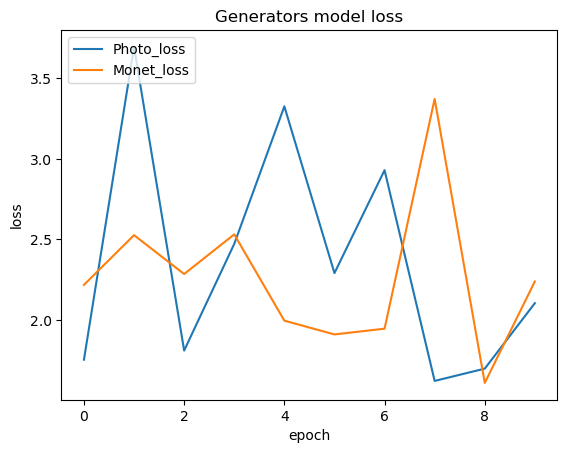

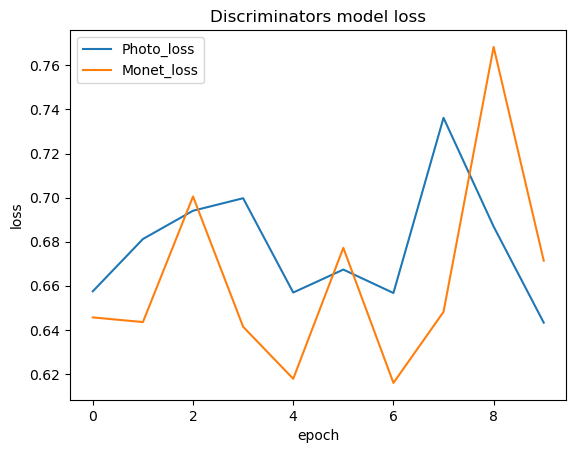

In [ ]:
cycle_gan_model.show_all_metrics()

## Experiment 2

### Hyper parameters

In [ ]:
LEARNING_RATE=0.0001
EPOCHS = 20

### Build model

In [ ]:
with strategy.scope():
    # Loss function for evaluating adversarial loss
    adv_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    # Define the loss function for the generators
    def generator_loss(fake):
        fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
        return fake_loss

    # Define the loss function for the discriminators
    def discriminator_loss(real, fake):
        real_loss = adv_loss_fn(tf.ones_like(real), real)
        fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
        return (real_loss + fake_loss) * 0.5
    
    cycle_gan_model = CycleGanModel()
    
    cycle_gan_model.build_cycle_Gan_model(gen_monet=CycleGanModel.create_generator(name="generator_monet"),
                                          gen_photo=CycleGanModel.create_generator(name="generator_photo"),
                                          discriminator_photo=CycleGanModel.create_discriminator(name="discriminator_photo", filters=512, num_downsampling=4),
                                          discriminator_monet=CycleGanModel.create_discriminator(name="discriminator_monet", filters=512, num_downsampling=4))
    cycle_gan_model.compile_model(gen_monet_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                                  gen_photo_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                                  disc_photo_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                                  disc_monet_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                                  gen_loss_function=generator_loss,
                                  disc_loss_function=discriminator_loss)

/opt/conda/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


### Train model

In [ ]:
# Here we will train the model for just one epoch as each epoch takes around
# 1.5 minutes on a single P100 backed machine.
cycle_gan_model.train_model(tf.data.Dataset.zip((photo_dataset, monet_dataset)),
                            epochs=EPOCHS)
cycle_gan_model.save('/content/drive/MyDrive/Experiment2')

Epoch 1/20
train_step
train_step
300/300 [==============================] - 228s 493ms/step - Photo_loss: 3.9289 - Monet_loss: 4.1214 - D_Photo_loss: 0.5631 - D_Monet_loss: 0.5441
Epoch 2/20
300/300 [==============================] - 149s 494ms/step - Photo_loss: 3.2275 - Monet_loss: 2.9660 - D_Photo_loss: 0.6508 - D_Monet_loss: 0.6632
Epoch 3/20
300/300 [==============================] - 149s 494ms/step - Photo_loss: 3.0490 - Monet_loss: 2.7760 - D_Photo_loss: 0.5744 - D_Monet_loss: 0.6783
Epoch 4/20
300/300 [==============================] - 149s 494ms/step - Photo_loss: 3.5156 - Monet_loss: 3.3963 - D_Photo_loss: 0.5003 - D_Monet_loss: 0.5008
Epoch 5/20
300/300 [==============================] - 149s 494ms/step - Photo_loss: 3.0643 - Monet_loss: 2.7536 - D_Photo_loss: 0.6591 - D_Monet_loss: 0.6781
Epoch 6/20
300/300 [==============================] - 149s 494ms/step - Photo_loss: 2.8199 - Monet_loss: 2.5973 - D_Photo_loss: 0.6641 - D_Monet_loss: 0.6628
Epoch 7/20
300/300 [==========

### Show Model graph

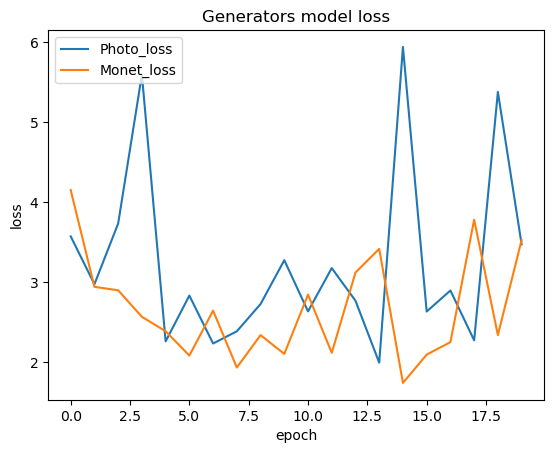

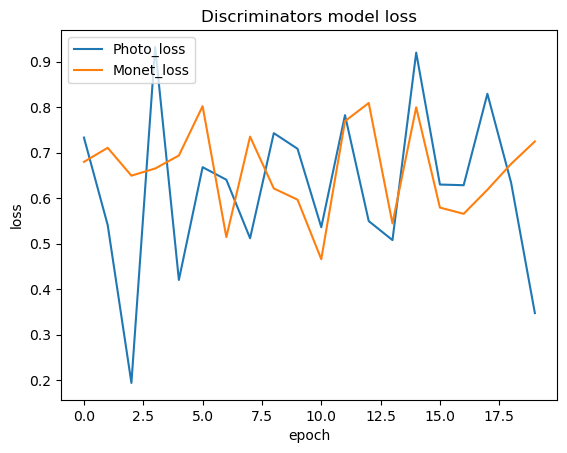

In [ ]:
cycle_gan_model.show_all_metrics()

## Best Model

### Hyper parameters

In [ ]:
LEARNING_RATE=0.0001
EPOCHS = 30

### Build model

In [ ]:
with strategy.scope():
    # Loss function for evaluating adversarial loss
    adv_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    # Define the loss function for the generators
    def generator_loss(fake):
        fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
        return fake_loss


    # Define the loss function for the discriminators
    def discriminator_loss(real, fake):
        real_loss = adv_loss_fn(tf.ones_like(real), real)
        fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
        return (real_loss + fake_loss) * 0.5
    
    cycle_gan_model = CycleGanModel()
    cycle_gan_model.build_cycle_Gan_model(gen_monet=CycleGanModel.create_generator(name="generator_monet"),
                                          gen_photo=CycleGanModel.create_generator(name="generator_photo"),
                                          discriminator_photo=CycleGanModel.create_discriminator(name="discriminator_photo"),
                                          discriminator_monet=CycleGanModel.create_discriminator(name="discriminator_monet"))
    cycle_gan_model.compile_model(gen_monet_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                                  gen_photo_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                                  disc_photo_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                                  disc_monet_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                                  gen_loss_function=generator_loss,
                                  disc_loss_function=discriminator_loss)
    

/opt/conda/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


### Train model

In [ ]:
# Here we will train the model for just one epoch as each epoch takes around
# 1.5 minutes on a single P100 backed machine.
cycle_gan_model.train_model(tf.data.Dataset.zip((photo_dataset, monet_dataset)),
                            epochs=EPOCHS)
cycle_gan_model.save('/content/drive/MyDrive/BestModel')

Epoch 1/30
train_step
train_step
300/300 [==============================] - 220s 468ms/step - Photo_loss: 3.7200 - Monet_loss: 3.8713 - D_Photo_loss: 0.6775 - D_Monet_loss: 0.6720
Epoch 2/30
300/300 [==============================] - 141s 468ms/step - Photo_loss: 2.9297 - Monet_loss: 2.7013 - D_Photo_loss: 0.6250 - D_Monet_loss: 0.6508
Epoch 3/30
300/300 [==============================] - 141s 468ms/step - Photo_loss: 2.7524 - Monet_loss: 2.5686 - D_Photo_loss: 0.6493 - D_Monet_loss: 0.6853
Epoch 4/30
300/300 [==============================] - 141s 468ms/step - Photo_loss: 2.7275 - Monet_loss: 2.4625 - D_Photo_loss: 0.6781 - D_Monet_loss: 0.6835
Epoch 5/30
300/300 [==============================] - 141s 468ms/step - Photo_loss: 2.4323 - Monet_loss: 2.3266 - D_Photo_loss: 0.6944 - D_Monet_loss: 0.6725
Epoch 6/30
300/300 [==============================] - 141s 468ms/step - Photo_loss: 2.3488 - Monet_loss: 2.2991 - D_Photo_loss: 0.6877 - D_Monet_loss: 0.6945
Epoch 7/30
300/300 [==========

### Show Model graph

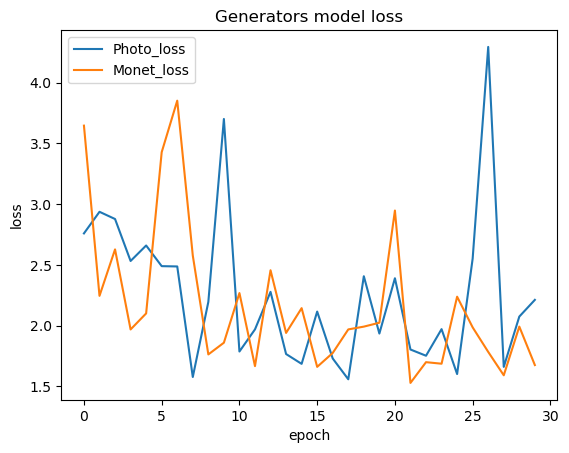

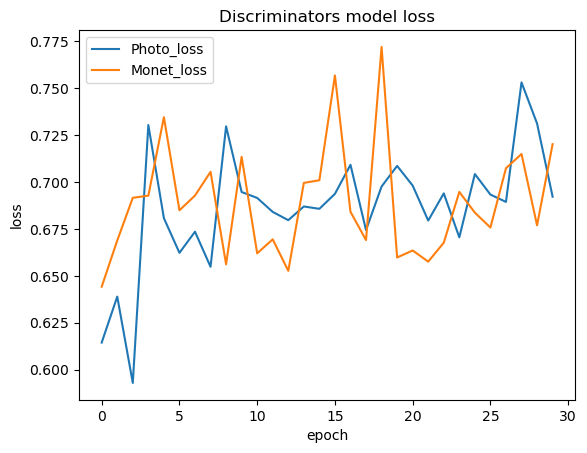

In [ ]:
cycle_gan_model.show_all_metrics()

## Making a single prediction

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1OHlZEKmqqAqf6PsYZ1NOg_qx9vegNuQk
To: /kaggle/working/BestModel-320x320.zip
100%|██████████████████████████████████████| 42.4M/42.4M [00:08<00:00, 4.86MB/s]


/opt/conda/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


(None, 320, 320, 3)


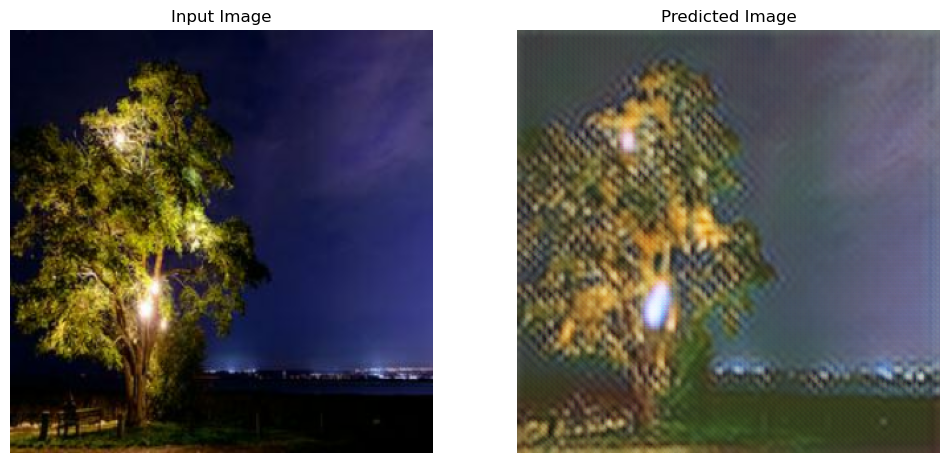

In [ ]:
def generate_images(model, 
                    test_input):
    print(model.input_shape)
    prediction = model(test_input)
    
    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 2, 1)
    plt.imshow(test_input[0])
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(prediction[0])
    plt.title('Predicted Image')
    plt.axis('off')

    plt.show()

best_model = CycleGanModel.load_best_model("BestModel-320x320")
    
for i, img in enumerate(photo_dataset.take(1)):
    generate_images(best_model, img)

# Neural Style Transfer

## Imports

In [ ]:
import os
import pickle
import random
import numpy as np
import tensorflow as tf
import math
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio
from google.colab import files

## Fetch Data

### Connect To Kaggle

In [ ]:
!pip install kaggle
!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!echo "{\"username\":\"danieloleynyk\",\"key\":\"d12717bbf9c130483a654f3b95be3356\"}" > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Download Dataset From Kaggle

In [ ]:
%%capture
!kaggle competitions download -c gan-getting-started
!rm -rf /kaggle/input
!mkdir -p /kaggle/input
!unzip gan-getting-started.zip -d /kaggle/input/gan-getting-started

## Define Kaggle Paths

In [ ]:
images_dir = '/kaggle/input/gan-getting-started/photo_jpg/'
styles_dir = '/kaggle/input/gan-getting-started/monet_jpg/'

## Build Class Model

In [ ]:
class NeuralStyleTransfer:
  pass

In [ ]:
class NeuralStyleTransfer(NeuralStyleTransfer):
  RESULT_PREFIX = "monet_generated"

  def __init__(
    self,
    optimizer = None,
    optimizer_args = None,
    optimizer_kwargs = None,
    style_layer_names = None,
    content_layer_name = 'block5_conv2',
    total_variation_weight = 1e-6,
    style_weight = 1e-6,
    content_weight = 2.5e-8,
    gen_img_height = 320, 
    gen_img_width = 320,
  ):
    model = tf.keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

    self.gen_img_height = gen_img_height
    self.gen_img_width = gen_img_width

    self.optimizer = optimizer if optimizer else keras.optimizers.SGD

    self.optimizer_kwargs = optimizer_kwargs if optimizer_kwargs is None else {}
    self.optimizer_args = optimizer_args if optimizer_args is None else [
      keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
      )
    ]

    self.content_layer_name = content_layer_name
    self.style_layer_names = style_layer_names if style_layer_names else [
      "block1_conv1",
      "block2_conv1",
      "block3_conv1",
      "block4_conv1",
      "block5_conv1",
    ]

    self.total_variation_weight = total_variation_weight
    self.style_weight = style_weight
    self.content_weight = content_weight
    self.feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=outputs_dict)

### Image Preprocessing Utils

#### Load Image

Used to take an image path and load it to a python object

In [ ]:
class NeuralStyleTransfer(NeuralStyleTransfer):
  def load_image(self, image_path):
      img = keras.preprocessing.image.load_img(
          image_path, target_size=(self.gen_img_height, self.gen_img_width)
      )
      return img

#### Preprocess Image

Used to take a raw image from the load image function and normalize it for our network

In [ ]:
class NeuralStyleTransfer(NeuralStyleTransfer):
  def preprocess_image(self, img):
      img = keras.preprocessing.image.img_to_array(img)
      img = np.expand_dims(img, axis=0)
      img = tf.keras.applications.vgg19.preprocess_input(img)
      return tf.convert_to_tensor(img)

#### Deprocess Image

Takes a vgg19 preprocessed image and reverse it to its original params, used for displaying the image after the preprocessing

In [ ]:
class NeuralStyleTransfer(NeuralStyleTransfer):
  def deprocess_image(self, x):
      x = x.reshape((self.gen_img_height, self.gen_img_width, 3))

      # Inverse of vgg19 preprocess step
      x[:, :, 0] += 103.939
      x[:, :, 1] += 116.779
      x[:, :, 2] += 123.68
      
      # 'BGR'->'RGB'
      x = x[:, :, ::-1]
      x = np.clip(x, 0, 255).astype("uint8")

      return x

### Loss Calculations Utils

#### Calculate Gram Matrix

In [ ]:
class NeuralStyleTransfer(NeuralStyleTransfer):
  @staticmethod
  def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

#### Calculate Style Loss

In [ ]:
class NeuralStyleTransfer(NeuralStyleTransfer):
  @staticmethod
  def style_loss(style, combination, img_shape):
    S = NeuralStyleTransfer.gram_matrix(style)
    C = NeuralStyleTransfer.gram_matrix(combination)
    channels = 3
    size = img_shape[0] * img_shape[1]
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))

#### Calculate Content Loss

In [ ]:
class NeuralStyleTransfer(NeuralStyleTransfer):
  def content_loss(self, base, combination):
    return tf.reduce_sum(tf.square(combination - base))

#### Calculate Total Variation Loss

In [ ]:
class NeuralStyleTransfer(NeuralStyleTransfer):
  @staticmethod
  def total_variation_loss(x, img_shape):
    a = tf.square(
        x[:, : img_shape[0] - 1, : img_shape[1] - 1, :] - x[:, 1:, : img_shape[1] - 1, :]
    )
    b = tf.square(
        x[:, : img_shape[0] - 1, : img_shape[1] - 1, :] - x[:, : img_shape[0] - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

### Loss Computing

In [ ]:
class NeuralStyleTransfer(NeuralStyleTransfer):
  def compute_loss(self, combination_image, base_image, style_reference_image):
      input_tensor = tf.concat(
          [base_image, style_reference_image, combination_image], axis=0
      )
      features = self.feature_extractor(input_tensor)

      # Initialize the loss
      loss = tf.zeros(shape=())

      # Add content loss
      layer_features = features[self.content_layer_name]
      base_image_features = layer_features[0, :, :, :]
      combination_features = layer_features[2, :, :, :]
      loss = loss + self.content_weight * self.content_loss(
          base_image_features, combination_features
      )

      # Add style loss
      for layer_name in self.style_layer_names:
          layer_features = features[layer_name]
          style_reference_features = layer_features[1, :, :, :]
          combination_features = layer_features[2, :, :, :]
          sl = self.style_loss(style_reference_features, combination_features, (self.gen_img_height, self.gen_img_width))
          loss += (self.style_weight / len(self.style_layer_names)) * sl

      # Add total variation loss
      loss += self.total_variation_weight * self.total_variation_loss(combination_image, (self.gen_img_height, self.gen_img_width))
      return loss

In [ ]:
class NeuralStyleTransfer(NeuralStyleTransfer):
  def compute_loss_and_grads(self, combination_image, base_image, style_reference_image):
      with tf.GradientTape() as tape:
        loss = self.compute_loss(combination_image, base_image, style_reference_image)
      grads = tape.gradient(loss, combination_image)
      return loss, grads

### Fit Utils

It's not possible to fit a neural style transfer algorithm/model, our function tries to calculate the average loss for a whole dir of images, using this function calculations we can later on generate a loss graph that will help us evaluate our architecture and hyperparameters performance

In [ ]:
class NeuralStyleTransfer(NeuralStyleTransfer):
  def fit(self, images_dir, styles_dir, training_size_limit=None, iterations=1000):
    losses =[[] for _ in range(iterations)]
    image_style_mapping = list(self.get_paths(images_dir, styles_dir, training_size_limit))

    for base_image_path, style_image_path in image_style_mapping:
      base_image = self.load_image(base_image_path)
      style_reference_image = self.load_image(style_image_path)

      optimizer = self.optimizer(*self.optimizer_args, **self.optimizer_kwargs)

      pre_base_image = self.preprocess_image(base_image)
      pre_style_reference_image = self.preprocess_image(style_reference_image)
      combination_image = tf.Variable(self.preprocess_image(base_image))
      
      for iteration in range(iterations):
        loss, grads = self.compute_loss_and_grads(combination_image, pre_base_image, pre_style_reference_image)
        optimizer.apply_gradients([(grads, combination_image)])
        losses[iteration].append(loss)

    losses = [sum(loss)/len(loss) for loss in losses]

    return losses

### Generation Utils

#### Generating Single Image

Takes a base image to translate, a style image, and metaparams such as patience, delta and max_iterations, which are used for early stopping the generate image algorithm.

In [ ]:
class NeuralStyleTransfer(NeuralStyleTransfer):
  def generate_image(self, base_image, style_image, patience=3, delta=20, max_iterations=10000, debug=False):
    prev_loss = float('inf')
    stagnation_count = 0

    optimizer = self.optimizer(*self.optimizer_args, **self.optimizer_kwargs)

    pre_base_image = self.preprocess_image(base_image)
    pre_style_reference_image = self.preprocess_image(style_image)
    combination_image = tf.Variable(self.preprocess_image(base_image))

    for i in range(max_iterations + 1):
      loss, grads = self.compute_loss_and_grads(combination_image, pre_base_image, pre_style_reference_image)
      optimizer.apply_gradients([(grads, combination_image)])

      if i % 100 == 0:
        if debug:
          print("Iteration %d: loss=%.2f" % (i, loss))
        
        img = self.deprocess_image(combination_image.numpy())
        fname = self.RESULT_PREFIX + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

        if loss >= prev_loss - delta:
          stagnation_count += 1
        else:
          stagnation_count = 0

        if stagnation_count >= patience:
          if debug:
            print(f'Early stopping after {i + 1} iterations.')
          return fname
      
        prev_loss = loss

    return fname;

#### Generate

Uses generate_image from the previous block to generate image translation for folder of images 

In [ ]:
class NeuralStyleTransfer(NeuralStyleTransfer):
  def generate(self, images_dir, styles_dir, limit=None, patience=3, delta=20, max_iterations=10000, debug=False):
    for base_image_path,style_image_path in self.get_paths(images_dir, styles_dir, limit):
      base_image = self.load_image(base_image_path)
      style_reference_image = self.load_image(style_image_path)
      generated_image_path = self.generate_image(base_image, style_reference_image, patience, delta, max_iterations, debug)
      self.show_images(base_image_path, style_image_path, generated_image_path)

### Model Utils

#### Get Paths

A util function that generates us tuples containing the image path from the images_dir and a random style monet image path to use later on in the algorithm

In [ ]:
class NeuralStyleTransfer(NeuralStyleTransfer):
  @staticmethod
  def get_paths(images_dir, styles_dir, limit=None):
    images = os.listdir(images_dir)

    if limit:
      images = images[:limit] if limit < len(images) else images

    for image in images:
      style_image_filename = random.choice(os.listdir(styles_dir))
      base_image_path = os.path.join(images_dir, image)
      style_image_path = os.path.join(styles_dir, style_image_filename)
      yield base_image_path, style_image_path

#### Show Loss Graph

In [ ]:
class NeuralStyleTransfer(NeuralStyleTransfer):
  @staticmethod
  def show_losses(losses):
    plt.plot(losses)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss1'], loc='upper left')
    plt.show()

#### Show Images

Takes the image path, style image path and the generated image path, and shows all 3 images side by side to see the results

image -> style -> generated_image

In [ ]:
class NeuralStyleTransfer(NeuralStyleTransfer):
  @staticmethod
  def show_images(image, style, generated_image):
    img1 = mpimg.imread(image)
    img2 = mpimg.imread(style)
    img3 = mpimg.imread(generated_image)

    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    axs[0].imshow(img1)
    axs[0].axis('off')

    axs[1].imshow(img2)
    axs[1].axis('off')

    axs[2].imshow(img3)
    axs[2].axis('off')

    plt.show()

## Display Example Results

Display 3 random images with and their respective monet style

In [ ]:
NeuralStyleTransfer().generate(images_dir, styles_dir, limit=3)

## Experiments

### Experiment 1

#### Params

In [ ]:
model_params = {
    'optimizer': keras.optimizers.SGD,
    'optimizer_kwargs': {},
    'optimizer_args': [
      keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
      )
    ],

    'content_layer_name': 'block5_conv2',
    'style_layer_names': [
      "block1_conv1",
      "block2_conv1",
      "block3_conv1",
      "block4_conv1",
      "block5_conv1",
    ],

    'total_variation_weight': 1e-6,
    'style_weight': 1e-6,
    'content_weight': 2.5e-8,
    'gen_img_height': 320,
    'gen_img_width': 320,
}

images_dir = '/kaggle/input/gan-getting-started/photo_jpg/'
styles_dir = '/kaggle/input/gan-getting-started/monet_jpg/'
training_size_limit = 2
iterations = 1000

#### Fit Model

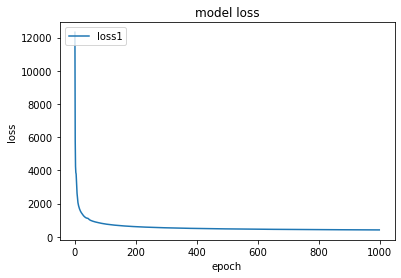

In [ ]:
def experiment_1(model_params, images_dir, styles_dir, training_size_limit, iterations):
  model = NeuralStyleTransfer(**model_params)
  losses = model.fit(images_dir, styles_dir, training_size_limit=training_size_limit, iterations=iterations)
  model.show_losses(losses)

experiment_1(model_params, images_dir, styles_dir, training_size_limit, iterations)

### Experiment 2

#### Params

In [ ]:
model_params = {
    'optimizer': keras.optimizers.Adam,
    'optimizer_kwargs': {
        "learning_rate": 0.02
    },
    'optimizer_args': [],

    'content_layer_name': 'block5_conv2',
    'style_layer_names': [
      "block1_conv1",
      "block2_conv1",
      "block3_conv1",
      "block4_conv1",
      "block5_conv1",
    ],

    'total_variation_weight': 1e-6,
    'style_weight': 1e-6,
    'content_weight': 2.5e-8,
    'gen_img_height': 320,
    'gen_img_width': 320,
}

images_dir = '/kaggle/input/gan-getting-started/photo_jpg/'
styles_dir = '/kaggle/input/gan-getting-started/monet_jpg/'
training_size_limit = 2
iterations = 1000

#### Fit Model

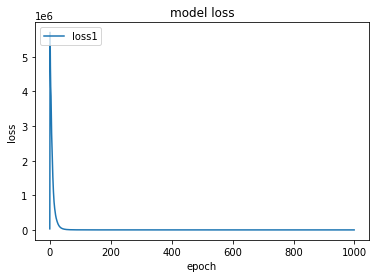

In [ ]:
def experiment_2(model_params, images_dir, styles_dir, training_size_limit, iterations):
  model = NeuralStyleTransfer(**model_params)
  losses = model.fit(images_dir, styles_dir, training_size_limit=training_size_limit, iterations=iterations)
  model.show_losses(losses)

experiment_2(model_params, images_dir, styles_dir, training_size_limit, iterations)

In [ ]:
style_layer_names =[ "block1_conv1",  "block2_conv1", "block3_conv1", "block4_conv1" ]
content_layer_name = "block4_conv2"
experiment_2(style_layer_names, content_layer_name)

### Experiment 3

#### Params

In [ ]:
model_params = {
    'optimizer': keras.optimizers.SGD,
    'optimizer_kwargs': {},
    'optimizer_args': [
      keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
      )
    ],
    
    'content_layer_name': 'block5_conv1',
    'style_layer_names': [
      "block1_conv2",
      "block2_conv2",
      "block3_conv2",
      "block4_conv2",
      "block5_conv2",
    ],

    'total_variation_weight': 1e-6,
    'style_weight': 1e-6,
    'content_weight': 2.5e-8,
    'gen_img_height': 320,
    'gen_img_width': 320,
}

images_dir = '/kaggle/input/gan-getting-started/photo_jpg/'
styles_dir = '/kaggle/input/gan-getting-started/monet_jpg/'
training_size_limit = 2
iterations = 1000

#### Fit Model

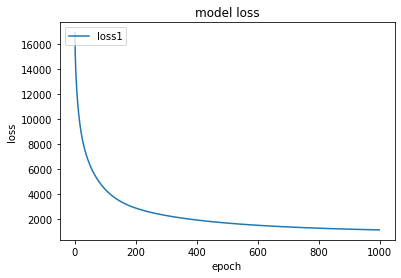

In [ ]:
def experiment_3(model_params, images_dir, styles_dir, training_size_limit, iterations):
  model = NeuralStyleTransfer(**model_params)
  losses = model.fit(images_dir, styles_dir, training_size_limit=training_size_limit, iterations=iterations)
  model.show_losses(losses)

experiment_3(model_params, images_dir, styles_dir, training_size_limit, iterations)

## Save Best Model

The first experiment has the best model

### Params

In [ ]:
model_params = {
    'optimizer': keras.optimizers.SGD,
    'optimizer_kwargs': {},
    'optimizer_args': [
      keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
      )
    ],

    'content_layer_name': 'block5_conv2',
    'style_layer_names': [
      "block1_conv1",
      "block2_conv1",
      "block3_conv1",
      "block4_conv1",
      "block5_conv1",
    ],

    'total_variation_weight': 1e-6,
    'style_weight': 1e-6,
    'content_weight': 2.5e-8,
    'gen_img_height': 320,
    'gen_img_width': 320,
}

images_dir = '/kaggle/input/gan-getting-started/photo_jpg/'
styles_dir = '/kaggle/input/gan-getting-started/monet_jpg/'
training_size_limit = 2
iterations = 1000

### Save Model

In [ ]:
best_model = NeuralStyleTransfer(**model_params)
with open('nst.model.obj', 'wb') as f:
  pickle.dump(best_model, f)